In [1]:
import scipy.signal as ss
import numpy as np
import matplotlib.pyplot as plt

# Spectrogram and Pwelch

Whilst seemingly simple and intuitive, the details of defining, scaling and interpreting a spectrogram or pwelch (Welch's estimate of the Power Spectral Density) have a number of subtleties that are important for analysis and processing of signal data. As with most things in signal processing, these come down to understanding the interplay between
- the physics and domain (typically characterized by the emitter, propagation to the receiver, and the characteristics of the receiver up to the ADC)
- the electrical engineering (understanding the physics and domain as transfer functions, and tracking the SNR and gain through the system)
- statistics and linear algebra

As far as linear algebra is concerned for this topic, the relevant aspect is that the data naturally sits in the complex domain (so a tonal is really a complex sinusoid) and the DFT is a unitary transformation between the time and frequency domain. This means that so long as one is in the complex domain, the algebraic difference between time and frequency is largely irrelevant, and allows one to perform 'coherent' processing (that is processing with phase). As soon as one removes the phase information (e.g. taking the magnitude of complex numbers), then the difference between time and frequency is no longer irrelevant, and one can only perform 'incoherent' processing (that is processing without phase).

### Test signal

Consider a tonal with random noise.

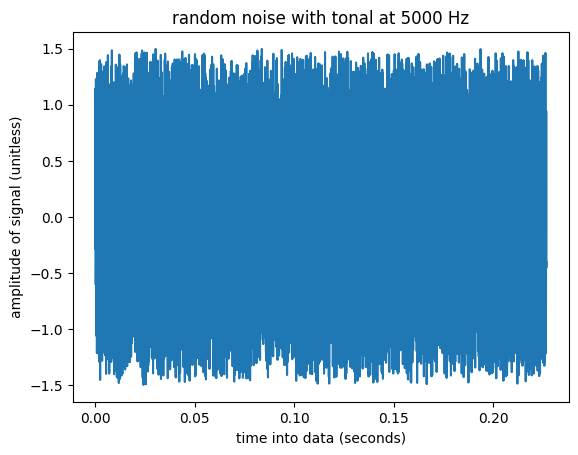

In [2]:
n_sample = 10000
fs = 44100  # sample rate in Hz
f_tonal = 5000  # tonal frequency in Hz
data = np.random.random(n_sample) - 0.5 + np.sin(np.arange(n_sample) * 2.0 * np.pi * f_tonal / fs)
plt.plot(np.arange(n_sample) / fs, data)
plt.xlabel("time into data (seconds)")
plt.ylabel("amplitude of signal (unitless)")
plt.title(f"random noise with tonal at {f_tonal} Hz")
plt.show()

### Pwelch

Welch's estimate for the PSD (Power Spectral Density) takes a number of FFTs, takes the magnitude of the resultant complex arrays, and takes a mean over the real arrays.

The two PSD estimates below are performed using the same method, except the FFT length (and corresponding overlap) have changed.

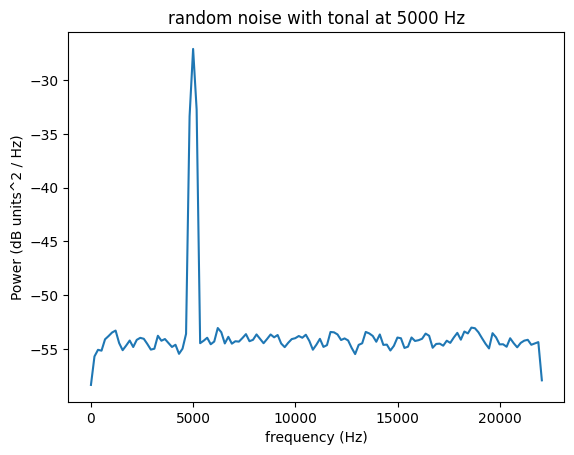

In [3]:
freqs, Pxx = ss.welch(
    data,  # array of raw samples
    fs,  # sample rate (in Hz) of input samples
    "hanning",  # window function to apply on each FFT window
    nperseg=256,  # length of the FFT windows
    noverlap=128,  # overlap of successive FFT windows; this means that the windows will cover [0, 256], [128, 384], [256, 512]....
    detrend=False,  # do not remove mean
    scaling="density"  # pwelch units will be units^2/Hz (which preserves the noise floor level as FFT length changes) rather than 
                       # units^2 (which preserves the sum of the power, i.e. sumsqr of the original signal).
)
plt.plot(freqs, 10 * np.log10(Pxx))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
plt.title(f"random noise with tonal at {f_tonal} Hz")
plt.show()

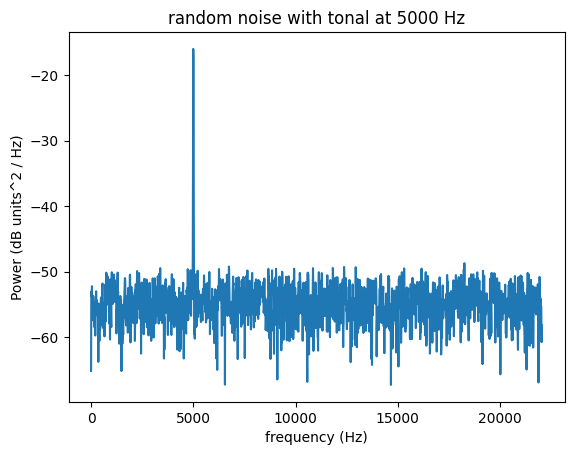

In [4]:
freqs, Pxx = ss.welch(data, fs, "hanning", nperseg=4096, noverlap=2048, detrend=False, scaling="density")
plt.plot(freqs, 10 * np.log10(Pxx))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
plt.title(f"random noise with tonal at {f_tonal} Hz")
plt.show()

For the longer FFT length, the tonal spike is sharper and more pronounced. This is because the longer FFT length has provided a high coherent processing gain.

For the shorter FFT length, there are more FFTs performed, meaning there are more real arrays that are fed into calculation for the mean, i.e. there is a higher amount of incoherent processing performed. Since more samples are going into the calculation of the sample mean, the noise floor 'gets flatter', i.e. the variance in the noise floor is reduced, representing incoherent processing gain.

#### Window function and overlap

From a Fourier analysis perspective, a DFT/FFT is a decomposition of a signal into (frequency bounded) Fourier series. This means that the decomposition obeys periodic boundary conditions... which is not ideal for taking the FFT of neighbouring windows; the edge effects of the window bring in ['circular' artefacts](https://www.modalshop.com/rental/learn/basics/how-to-choose-fft-window) of the Fourier decomposition wrapping around the window. To counteract this, the edge effects are suppressed with a window function across the window. However, since the samples on the edge are now suppressed, an overlap of windows is provided so that all (interior) samples have the chance to be toward the middle of the window.

The window function and overlap provide parameters one can tune for processing, although more often than not, one uses a Hanning window with an overlap equal to half the FFT length (which is often a power of 2, for FFT optimization).

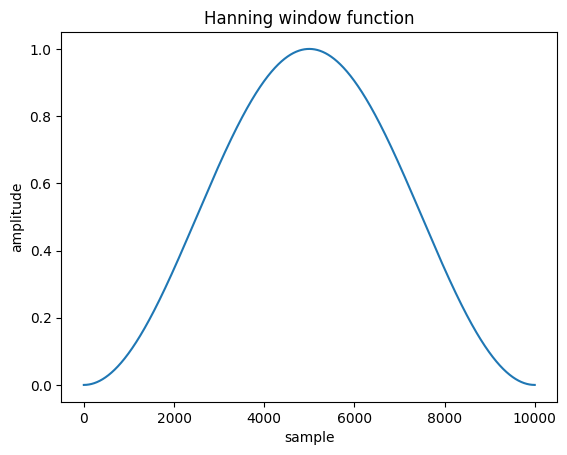

In [5]:
plt.plot(ss.windows.hann(n_sample))
plt.xlabel("sample")
plt.ylabel("amplitude")
plt.title("Hanning window function")
plt.show()

Changing the window function can alter how sensitive the resultant FFT signal is to non-periodic boundary conditions, and can alter the shape of a response in the frequency domain. Whilst the changes are not usually dramatic, they can be tuned for the data and analysis at hand.

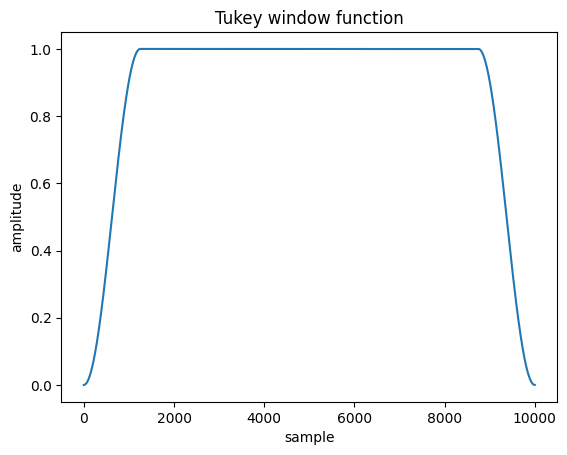

In [6]:
plt.plot(ss.windows.tukey(n_sample, 0.25))
plt.xlabel("sample")
plt.ylabel("amplitude")
plt.title("Tukey window function")
plt.show()

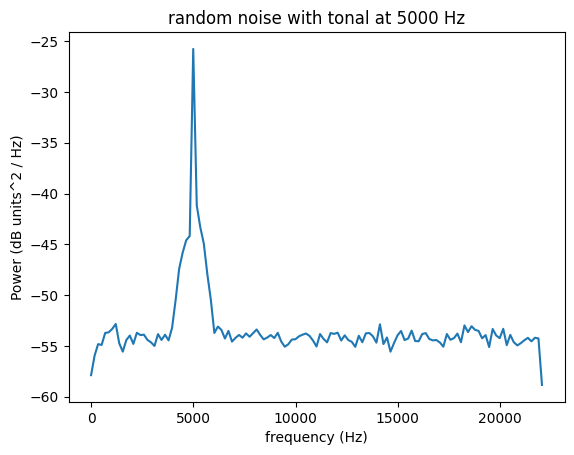

In [7]:
freqs, Pxx = ss.welch(data, fs, ("tukey", 0.25), nperseg=256, noverlap=128, detrend=False, scaling="density")
plt.plot(freqs, 10 * np.log10(Pxx))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
plt.title(f"random noise with tonal at {f_tonal} Hz")
plt.show()

### Spectrogram

The methodology and issues described above are slightly easier to see in a spectrogram. Indeed, since the processing for a spectrogram is identical to that of a pwelch, the interface is also the same.

In [8]:
freqs, times, Sxx = ss.spectrogram(
    data,  # array of raw samples
    fs,  # sample rate (in Hz) of input samples
    "hanning",  # window function to apply on each FFT window
    nperseg=256,  # length of the FFT windows
    noverlap=128,  # overlap of successive FFT windows; this means that the windows will cover [0, 256], [128, 384], [256, 512]....
    detrend=False,  # do not remove mean
    scaling="density"  # spectrogram units will be units^2/Hz (which preserves the noise floor level as FFT length changes) rather than 
                       # units^2 (which preserves the sum of the power, i.e. sumsqr of the original signal).
)
print(Sxx.shape)

(129, 77)


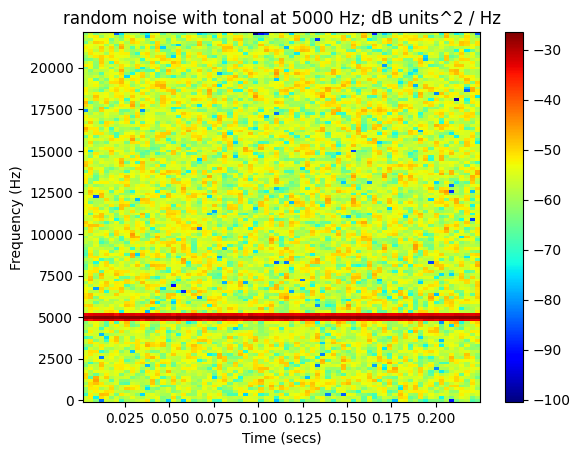

In [9]:
plt.pcolormesh(times, freqs, 10 * np.log10(Sxx), shading="nearest", cmap="jet")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (secs)")
plt.title(f"random noise with tonal at {f_tonal} Hz; dB units^2 / Hz")
plt.colorbar()
plt.show()

The only additional step to get the pwelch, is to take a mean over the time axis

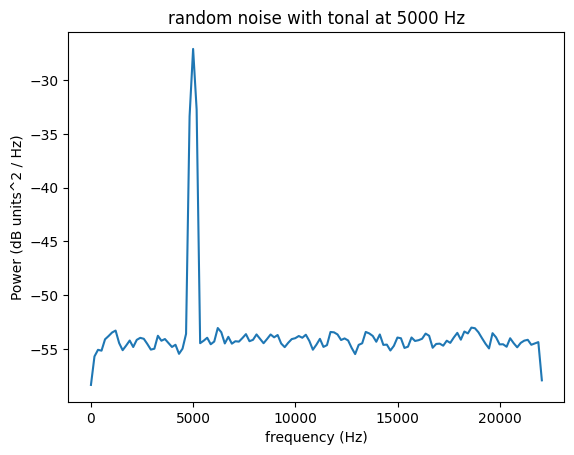

In [10]:
plt.plot(freqs, 10 * np.log10(np.mean(Sxx, axis=1)))
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB units^2 / Hz)")
plt.title(f"random noise with tonal at {f_tonal} Hz")
plt.show()

Similarly, one can see the effect of increasing the FFT window length; there are now more frequency bins and fewer time samples

In [11]:
freqs, times, Sxx = ss.spectrogram(data, fs, "hanning", nperseg=4096, noverlap=2048, detrend=False, scaling="density")
print(Sxx.shape)

(2049, 3)


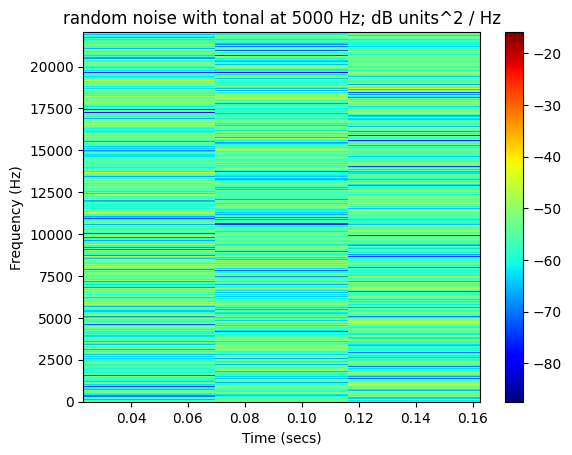

In [12]:
plt.pcolormesh(times, freqs, 10 * np.log10(Sxx), shading="nearest", cmap="jet")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (secs)")
plt.title(f"random noise with tonal at {f_tonal} Hz; dB units^2 / Hz")
plt.colorbar()
plt.show()

If needed, one can oversample in the time axis by increasing the overlap. Note that this does not add any extra information or increase the temporal resolution, this is just an upscale.

In [13]:
freqs, times, Sxx = ss.spectrogram(data, fs, "hanning", nperseg=4096, noverlap=3500, detrend=False, scaling="density")
print(Sxx.shape)

(2049, 10)


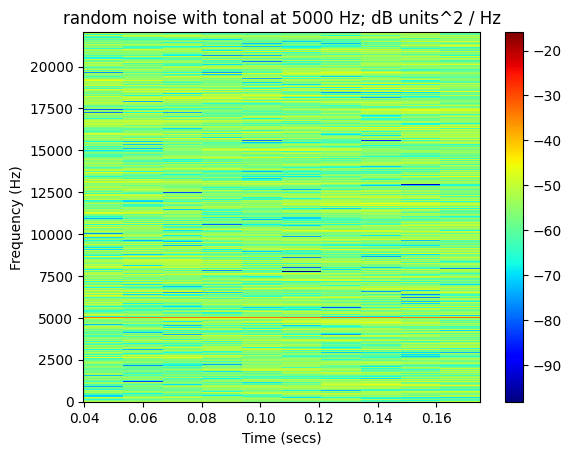

In [14]:
plt.pcolormesh(times, freqs, 10 * np.log10(Sxx), shading="nearest", cmap="jet")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (secs)")
plt.title(f"random noise with tonal at {f_tonal} Hz; dB units^2 / Hz")
plt.colorbar()
plt.show()

In changing the FFT length, one is exchanging frequency bins for time samples. In the extreme cases, one retrieves either the original time series (i.e. one frequency bin) or a FFT over the whole signal (i.e. one time sample). Choosing the FFT length is a subtle question, and is usually a design question based on the data, and the intelligence one is trying to extract from the data.

For a single simple signal, the choice of FFT length feels like a choice between temporal and frequency resolution. Note that this is often compared to the uncertainty principle in quantum mechanics, which is nonsense. This is simply conservation of information.

For signals with multiple components, or multi-signal data, the FFT length can represent a time scale for integrating out certain behaviour. In this sense, the choice of FFT length (or running a bank of spectrograms with different FFT lengths) is more akin to selecting certain wavelet scales in a wavelet transform for analysis. Whilst in principle, one can try working with wavelets and using DWTs, in practice, one can get pretty far with just spectrogramming (the efficiency of an FFT makes using a spectrogram and tuning spectrogram parameters an attractive choice).

In [15]:
for fft_length in 2 ** np.arange(1, 14):
    freqs, times, Sxx = ss.spectrogram(data, fs, "hanning", nperseg=fft_length, noverlap=fft_length/2, detrend=False, scaling="density")
    print(f"FFT length: {fft_length}, spectrogram shape {Sxx.shape}")

FFT length: 2, spectrogram shape (2, 9999)
FFT length: 4, spectrogram shape (3, 4999)
FFT length: 8, spectrogram shape (5, 2499)
FFT length: 16, spectrogram shape (9, 1249)
FFT length: 32, spectrogram shape (17, 624)
FFT length: 64, spectrogram shape (33, 311)
FFT length: 128, spectrogram shape (65, 155)
FFT length: 256, spectrogram shape (129, 77)
FFT length: 512, spectrogram shape (257, 38)
FFT length: 1024, spectrogram shape (513, 18)
FFT length: 2048, spectrogram shape (1025, 8)
FFT length: 4096, spectrogram shape (2049, 3)
FFT length: 8192, spectrogram shape (4097, 1)


### Slow time/fast time partitioning

The examples above show how to extract spectral information over a window, and how to arrange the data to extract that spectral information. From a practical perspective, these are examples of a wider analysis technique, which is partitioning the 1d data into 2d data, based on some kind of scale.

In [16]:
scale = 256  # scale in samples
overlap = int(scale / 2)  # overlap of successive scale windows just in case the oversampling is needed
stride = (scale - overlap)
n_window = int((len(data) - scale) / stride)

partitioned = []
for ctr in range(n_window):
    partitioned.append(data[ctr * stride: ctr * stride + scale])

print(np.shape(partitioned))

(76, 256)


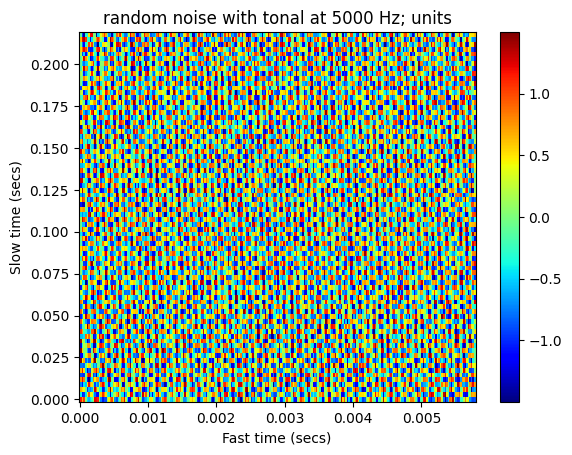

In [22]:
fast_times = np.arange(scale) / fs
slow_times = np.arange(n_window) * stride / fs

plt.pcolormesh(fast_times, slow_times, partitioned, shading="nearest", cmap="jet")
plt.ylabel("Slow time (secs)")
plt.xlabel("Fast time (secs)")
plt.title(f"random noise with tonal at {f_tonal} Hz; units")
plt.colorbar()
plt.show()

In the resultant 2D array, the samples from a 1D array have been re-arranged into 2D array. This 2D array has 2 time axes, one of which (the axis of length $scale$ is at the original sample rate $f_s$ Hz, and the other axis is at a slower rate of $f_s / stride$ Hz. This represents a slow/fast time partition. One can algebraically summarize this operation as moving from a signal $x(t)$ to a two parameter function $X(t, \tau)$, where $t$ is the 'fast time' variable, and $\tau$ is the 'slow time' variable.

Using $\mathcal{F}$ to denote the Fourier transform (and dropping window functions for pedagogy), the trivial window functioned spectrogram becomes $\lvert \mathcal{F}_{t\rightarrow f}X(f, \tau) \rvert$ and Welch's spectral estimate becomes $\int d\tau \lvert \mathcal{F}_{t\rightarrow f}X(f, \tau) \rvert$. Keeping the phase (i.e. not performing the abs) yields the object \mathcal{F}_{t\rightarrow f}X(f, \tau)

Now we have a two-parameter function $X$, (which in the sampled world, is just a 2D array). For a pair of linear operations on those two variables (where each linear operation only affects onf of the variables), one can reorder the operations (and get the same answer). If those linear operations are invertible, they can be undone by applying the relevant inverse. Recall that the DFT is represented by a unitary matrix, which is an invertible linear transformation. This means that in the two variables for $X$, one can Fourier transform forward and back in the two variables to one's hearts content, either first on fast time or slow time, and the actual function doesn't actually (algebraically) change, only the basis against which it is decomposed. However, any non-linear or non-invertible operation will break this. Such examples are taking the abs value; this removes the phase and subsequent operations will be 'incoherent' (since phase information is lost) rather than 'coherent'. Once phase is lost, it cannot be recovered. Also, any multiplication by zero (whilst linear, is non-invertible) will be non-invertible.

As a corollary, the double Fourier transform into fast frequency and slow frequency is well-defined (i.e. the Fourier transform operations commute) $\mathcal{F}_{\tau\rightarrow\omega} \mathcal{F}_{t\rightarrow f}X(f, \omega) = \mathcal{F}_{t\rightarrow f}\mathcal{F}_{\tau\rightarrow\omega} X(f, \omega)$

In this sense (as per the spectrogram and Welch's estimate), $X(t, \tau)$ becomes a tool to explore $x(t)$, although does depend on a scale chosen to define the slow/fast time partition.

#### Choice of scale

This usually depends on the signals one wishes to prosecute (and so depends on the physics and electrical engineering). Some examples are:
- Synthetic Aperture Radar (SAR), where the length scale is the time for a radar pulse to be sent out and returned (fast time then represents the radar pulse travel, and slow time the platform motion)
- Envelope demodulation, where the length scale is chosen so that carrier frequencies are supported in fast frequency, and the modulation frequencies are supported in slow frequency
- Channelising by frequency, as a cheap form of building a bank of band pass filters, since the channelisation also in effect also downsample the data